# Part 1: Training a Linear model with Trainable Basis Functions

In [1]:
# Libraries related to PyTorch
import torch
from torch import Tensor
import torchaudio 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import WeightedRandomSampler,DataLoader
import torch.optim as optim

# Libraries related to hydra
import hydra
from hydra.utils import to_absolute_path
from omegaconf import DictConfig, OmegaConf

# custom packages
from dataset.speechcommands import SPEECHCOMMANDS_12C #for 12 classes KWS task
import models as Model 

# Libraries related to PyTorch Lightning
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule

# Libraries used in ligthning module
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import precision_recall_fscore_support
from dataset.speechcommands import idx2name, name2idx
from sklearn.metrics import confusion_matrix
import numpy as np
import re
import itertools

# nnAudio Front-end
from nnAudio.features.mel import MelSpectrogram, STFT

/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


# Configuration 

In [16]:
device = 'cuda:0'
gpus = 1
batch_size= 100
max_epochs = 200
check_val_every_n_epoch = 2
num_sanity_val_steps = 5

data_root= './' # Download the data here
download_option= False

n_mels= 40 
#number of Mel bases

input_dim= (n_mels*101)
output_dim= 12

random_mel= False   
#To control random initial mel bases  

# nnAudio guideline for trainable basis functions 
```
nnAudio.features.mel.MelSpectrogram(trainable_mel= ,trainable_STFT=) 
```
The function above is controlling if mel bases and STFT trainable

* A. Both Mel and STFT are non-trainable: 
`trainable_mel=False, trainable_STFT=False`
* B. Mel is trainable while STFT is fixed: 
`trainable_mel=True, trainable_STFT=False`
* C. gMel is fixed while gSTFT is trainable: 
`trainable_mel=False, trainable_STFT=True`
* D. Both gMel and gSTFT are trainable:
`trainable_mel=True, trainable_STFT=True`

In [11]:
mel_layer = MelSpectrogram(sr=16000, 
                           n_fft=480,
                           win_length=None,
                           n_mels=n_mels, 
                           hop_length=160,
                           window='hann',
                           center=True,
                           pad_mode='reflect',
                           power=2.0,
                           htk=False,
                           fmin=0.0,
                           fmax=None,
                           norm=1,
                           trainable_mel=False,
                           trainable_STFT=True,
                           verbose=True)

STFT kernels created, time used = 0.0221 seconds
STFT filter created, time used = 0.0021 seconds
Mel filter created, time used = 0.0021 seconds


# Setting up dataset

In [4]:
trainset = SPEECHCOMMANDS_12C(root=data_root,
                              url='speech_commands_v0.02',
                              folder_in_archive='SpeechCommands',
                              download= download_option,subset= 'training') 

validset = SPEECHCOMMANDS_12C(root=data_root,
                              url='speech_commands_v0.02',
                              folder_in_archive='SpeechCommands',
                              download= download_option,subset= 'validation')

testset = SPEECHCOMMANDS_12C(root=data_root,
                              url='speech_commands_v0.02',
                              folder_in_archive='SpeechCommands',
                              download= download_option,subset= 'testing')

basename='speech_commands_v0.02.tar.gz'


Loading training set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84843/84843 [00:25<00:00, 3295.02it/s]


basename='speech_commands_v0.02.tar.gz'


Loading validation set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9981/9981 [00:02<00:00, 3339.42it/s]


basename='speech_commands_test_set_v0.02.tar.gz'


Loading testing set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4890/4890 [00:01<00:00, 3513.41it/s]


# Data rebalancing

For class weighting, rebalancing silence(10th class) and unknown(11th class) in training set

In [5]:
class_weights = [1,1,1,1,1,1,1,1,1,1,4.6,1/17]
sample_weights = [0] * len(trainset)
#create a list as per length of trainset

for idx, (data,rate,label,speaker_id, _) in enumerate(trainset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
#apply sample_weights in each data base on their label class in class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights),replacement=True)

# Data processing and loading

In [6]:
#Data processing
def data_processing(data):
    waveforms = []
    labels = []
    
    for batch in data:
        waveforms.append(batch[0].squeeze(0)) #after squeeze => (audio_len) tensor # remove batch dim
        labels.append(batch[2])      
        
    waveform_padded = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)  
    
    output_batch = {'waveforms': waveform_padded, 
             'labels': torch.tensor(labels),
             }
    return output_batch

# load data
trainloader = DataLoader(trainset,                                
                              collate_fn=lambda x: data_processing(x),
                                         batch_size=batch_size,sampler=sampler)

validloader = DataLoader(validset,                               
                              collate_fn=lambda x: data_processing(x),
                                         batch_size=batch_size)

testloader = DataLoader(testset,   
                              collate_fn=lambda x: data_processing(x),
                                        batch_size=batch_size)    

# Ligthning module

In [7]:
class SpeechCommand(LightningModule):
    def training_step(self, batch, batch_idx):
        outputs, spec = self(batch['waveforms']) 
        #return outputs [2D] for calculate loss, return spec [3D] for visual
        loss = self.criterion(outputs, batch['labels'].long())

        acc = sum(outputs.argmax(-1) == batch['labels'])/outputs.shape[0] #batch wise
        
        self.log('Train/acc', acc, on_step=False, on_epoch=True)
        if batch_idx == 0:
            self.log_images(spec, 'Train/Spec')
            cm = plot_confusion_matrix(batch['labels'].cpu(),
                                       outputs.argmax(-1).cpu(),
                                       name2idx.keys(),
                                       title='Train: Confusion matrix',
                                       normalize=False)
            self.logger.experiment.add_figure('Train/confusion_maxtrix', cm, global_step=self.current_epoch)            
        self.log('Train/Loss', loss, on_step=False, on_epoch=True)
        #log(graph title, take acc as data, on_step: plot every step, on_epch: plot every epoch)
        return loss

     
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx,
                       optimizer_closure, on_tpu, using_native_amp, using_lbfgs):
        
        optimizer.step(closure=optimizer_closure)
        with torch.no_grad():
            torch.clamp_(self.mel_layer.mel_basis, 0, 1)
        #after optimizer step, do clamp function on mel_basis (only applicable for nnAudio)
        #FastAudio internal has clamp function
        
   
    def validation_step(self, batch, batch_idx):               
        outputs, spec = self(batch['waveforms'])
        loss = self.criterion(outputs, batch['labels'].long())        
       
        self.log('Validation/Loss', loss, on_step=False, on_epoch=True)          

        if batch_idx == 0:
            fig, axes = plt.subplots(1,1)            
            mel_filter_banks = self.mel_layer.mel_basis
            for i in mel_filter_banks:
                axes.plot(i.cpu())

            self.logger.experiment.add_figure(
                'Validation/MelFilterBanks',
                fig,
                global_step=self.current_epoch)
                
        #these is for plot mel filter band in nnAudio 
        #fbank_matrix contain all FastAudio filterbank value (mel bases)
        
        if batch_idx == 0:           
            fig, axes = plt.subplots(2,2)
            for ax, kernel_num in zip(axes.flatten(), [2,10,20,50]):
                ax.plot(self.mel_layer.stft.wsin[kernel_num,0].cpu())  #STFT in included in Melspectrogram()
                ax.set_ylim(-1,1)
                fig.suptitle('sin')

            self.logger.experiment.add_figure(
                    'Validation/sin',
                    fig,
                    global_step=self.current_epoch)

            fig, axes = plt.subplots(2,2)
            for ax, kernel_num in zip(axes.flatten(), [2,10,20,50]):
                ax.plot(self.mel_layer.stft.wcos[kernel_num,0].cpu())
                ax.set_ylim(-1,1)
                fig.suptitle('cos')

            self.logger.experiment.add_figure(
                    'Validation/cos',
                    fig,
                    global_step=self.current_epoch)

        self.log_images(spec, 'Validation/Spec')
        #plot log_images for 1st epoch_1st batch
        
            
        output_dict = {'outputs': outputs,
                       'labels': batch['labels']}        
        return output_dict

    
    def validation_epoch_end(self, outputs):
        pred = []
        label = []
        for output in outputs:
            pred.append(output['outputs'])
            label.append(output['labels'])
        label = torch.cat(label, 0)
        pred = torch.cat(pred, 0)
        acc = sum(pred.argmax(-1) == label)/label.shape[0]
        
        cm = plot_confusion_matrix(label.cpu(),
                                   pred.argmax(-1).cpu(),
                                   name2idx.keys(),
                                   title='Validation: Confusion matrix',
                                   normalize=False)
        self.logger.experiment.add_figure('Validation/confusion_maxtrix', cm, global_step=self.current_epoch)
        
        self.log('Validation/acc', acc, on_step=False, on_epoch=True)    
        #use the return value from validation_step: output_dict , to calculate the overall accuracy   
        #epoch wise 
                              
    def test_step(self, batch, batch_idx):               
        outputs, spec = self(batch['waveforms'])
        loss = self.criterion(outputs, batch['labels'].long())        

        self.log('Test/Loss', loss, on_step=False, on_epoch=True)          

        if batch_idx == 0:
            fig, axes = plt.subplots(1,1)           
            mel_filter_banks = self.mel_layer.mel_basis
            for i in mel_filter_banks:
                axes.plot(i.cpu())

            self.logger.experiment.add_figure(
                'Test/MelFilterBanks',
                fig,
                global_step=self.current_epoch)
                
        #for plotting mel bases in nnAudio 
        #fbank_matrix contain all FastAudio filterbank value (mel bases)
            
            self.log_images(spec, 'Test/Spec')
        #plot log_images for 1st epoch_1st batch
        
        output_dict = {'outputs': outputs,
                       'labels': batch['labels']}        
        return output_dict

    
    def test_epoch_end(self, outputs):
        pred = []
        label = []
        for output in outputs:
            pred.append(output['outputs'])
            label.append(output['labels'])
        label = torch.cat(label, 0)
        pred = torch.cat(pred, 0)
        
        result_dict = {}
        for key in [None, 'micro', 'macro', 'weighted']:
            result_dict[key] = {}
            p, r, f1, _ = precision_recall_fscore_support(label.cpu(), pred.argmax(-1).cpu(), average=key, zero_division=0)
            result_dict[key]['precision'] = p
            result_dict[key]['recall'] = r
            result_dict[key]['f1'] = f1
            
        barplot(result_dict, 'precision')
        barplot(result_dict, 'recall')
        barplot(result_dict, 'f1')
            
        acc = sum(pred.argmax(-1) == label)/label.shape[0]
        self.log('Test/acc', acc, on_step=False, on_epoch=True)
        
        self.log('Test/micro_f1', result_dict['micro']['f1'], on_step=False, on_epoch=True)
        self.log('Test/macro_f1', result_dict['macro']['f1'], on_step=False, on_epoch=True)
        self.log('Test/weighted_f1', result_dict['weighted']['f1'], on_step=False, on_epoch=True)
        
        cm = plot_confusion_matrix(label.cpu(),
                                   pred.argmax(-1).cpu(),
                                   name2idx.keys(),
                                   title='Test: Confusion matrix',
                                   normalize=False)
        self.logger.experiment.add_figure('Test/confusion_maxtrix', cm, global_step=self.current_epoch)        
        
        torch.save(result_dict, "result_dict.pt")        
        
        return result_dict
        
    def log_images(self, tensors, key):
        fig, axes = plt.subplots(2,2, figsize=(12,5), dpi=100)
        for ax, tensor in zip(axes.flatten(), tensors):
            ax.imshow(tensor.cpu().detach(), aspect='auto', origin='lower', cmap='jet')
        plt.tight_layout()
        self.logger.experiment.add_figure(f"{key}", fig, global_step=self.current_epoch)
        plt.close(fig)
        #plot images in TensorBoard        
    
    
    def configure_optimizers(self):
        model_param = []
        for name, params in self.named_parameters():
            if 'mel_layer.' in name:
                pass
            else:
                model_param.append(params)          
        optimizer = optim.SGD([
                                {"params": self.mel_layer.parameters(),
                                 "lr": 1e-3,
                                 "momentum": 0.9,
                                 "weight_decay": 0.001},
                                {"params": model_param,
                                 "lr": 1e-3,
                                 "momentum": 0.9,
                                 "weight_decay": 0.001}            
                              ])
        #for applying diff lr in model and mel bases function       


def barplot(result_dict, title, figsize=(4,12), minor_interval=0.2, log=False):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    metric = {}
    for idx, item in enumerate(result_dict[None][title]):
        metric[idx2name[idx]] = item
    xlabels = list(metric.keys())
    values = list(metric.values())
    if log:
        values = np.log(values)
    ax.barh(xlabels, values)
    ax.tick_params(labeltop=True, labelright=False)
    ax.xaxis.grid(True, which='minor')
    ax.xaxis.set_minor_locator(MultipleLocator(minor_interval))
    ax.set_ylim([-1,len(xlabels)])
    ax.set_title(title)
    ax.grid(axis='x')
    ax.grid(b=True, which='minor', linestyle='--')
    fig.savefig(f'{title}.png', bbox_inches='tight')
    fig.tight_layout() # prevent edge from missing
#         fig.set_tight_layout(True)
    return fig
          
    
def plot_confusion_matrix(correct_labels,
                          predict_labels,
                          labels,
                          title='Confusion matrix',
                          normalize=False):
    ''' 
    Parameters:
        correct_labels                  : These are your true classification categories.
        predict_labels                  : These are you predicted classification categories
        labels                          : This is a lit of labels which will be used to display the axix labels
        title='Confusion matrix'        : Title for your matrix
        tensor_name = 'MyFigure/image'  : Name for the output summay tensor

    Returns:
        summary: TensorFlow summary 

    Other itema to note:
        - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
        - Currently, some of the ticks dont line up due to rotations.
    '''
    cm = confusion_matrix(correct_labels, predict_labels, labels=range(len(labels)))
    if normalize:
        cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm, copy=True)
        cm = cm.astype('int')

    np.set_printoptions(precision=2)

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=160, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, cmap='Oranges')

    classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in labels]
    #classes = ['\n'.join(l) for l in classes]

    tick_marks = np.arange(len(classes))

    ax.set_xlabel('Predicted', fontsize=7)
    ax.set_xticks(tick_marks)
    c = ax.set_xticklabels(classes, fontsize=6, rotation=0,  ha='center')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True Label', fontsize=7)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=6, va ='center')
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
    fig.set_tight_layout(True)


    return fig

# Setting up model

In [13]:
class Linearmodel_nnAudio(SpeechCommand):
    def __init__(self): 
        super().__init__()
        self.mel_layer = mel_layer       
        self.criterion = nn.CrossEntropyLoss()
        self.linearlayer = nn.Linear(input_dim, output_dim)
        #cfg.model.args.input_dim will be calculated in training script 
   
        if random_mel == True:
            nn.init.kaiming_uniform_(self.mel_layer.mel_basis, mode='fan_in')
            self.mel_layer.mel_basis.requires_grad = False
            torch.relu_(self.mel_layer.mel_basis)
            self.mel_layer.mel_basis.requires_grad = True
            #for randomly initialize mel bases
    
    def forward(self, x): 
        #x: 2D [B, 16000]
        spec = self.mel_layer(x)  
        #spec: 3D [B, F40, T101]
        
        spec = torch.log(spec+1e-10)
        flatten_spec = torch.flatten(spec, start_dim=1) 
        #flatten_spec: 2D [B, F*T(40*101)] 
        #start_dim: flattening start from 1st dimention
        
        out = self.linearlayer(flatten_spec) 
        #out: 2D [B,number of class(12)] 
                               
        return out, spec 

# nnAudio is integrated into the model at line 50 of models/nnAudio_model.py 
net = Linearmodel_nnAudio()

In [14]:
net = net.to(device)

# Training model

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/pytorch_lightning/trainer/optimizers.py:37: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name        | Type             | Params
-------------------------------------------------
0 | mel_layer   | MelSpectrogram   | 231 K 
1 | criterion   | CrossEntropyLoss | 0     
2 | linearlayer | Linear           | 48.5 K
-------------------------------------------------
279 K     Trainable params
0         Non-trainable params
279 K     Total params
1.119     Total estimated model params size (MB)


Validation sanity check:   0%|                                                                                                                                                        | 0/5 [00:00<?, ?it/s]

/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 856/958 [00:12<00:01, 71.17it/s, loss=8.91, v_num=11]
Validating: 0it [00:00, ?it/s]
Validating:  36%|███████████████████████████████████████████████████████▊                                                                                                  | 37/102 [00:18<00:59,  1.10it/s]


Validating:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 76/102 [00:36<00:11,  2.30it/s]


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [01:00<00:00, 15.75it/s, loss=8.91, v_num=11]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/root/anaconda3/envs/python3.8.10/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 32/49 [00:00<00:00, 58.34it/s]

/tmp/ipykernel_22959/3003781365.py:219: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')
/tmp/ipykernel_22959/3003781365.py:219: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')
/tmp/ipykernel_22959/3003781365.py:219: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--')


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Loss': 8.974884986877441,
 'Test/acc': 0.08077710121870041,
 'Test/macro_f1': 0.028011448681354523,
 'Test/micro_f1': 0.08077709376811981,
 'Test/weighted_f1': 0.027876824140548706}
--------------------------------------------------------------------------------
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.09it/s]


[{'Test/Loss': 8.974884986877441,
  'Test/acc': 0.08077710121870041,
  'Test/micro_f1': 0.08077709376811981,
  'Test/macro_f1': 0.028011448681354523,
  'Test/weighted_f1': 0.027876824140548706}]

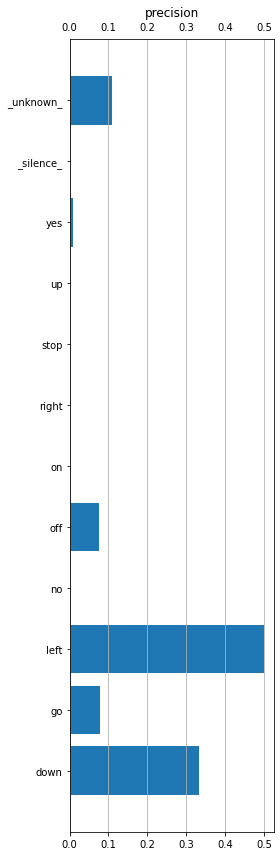

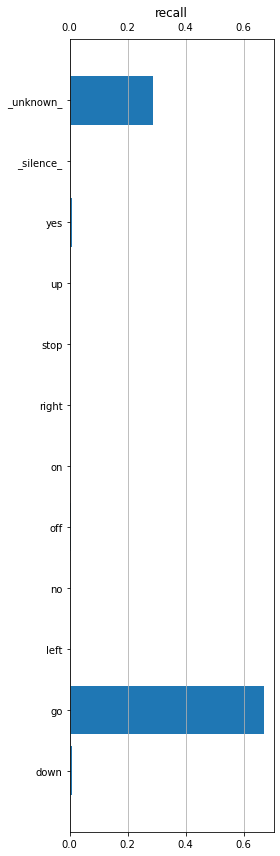

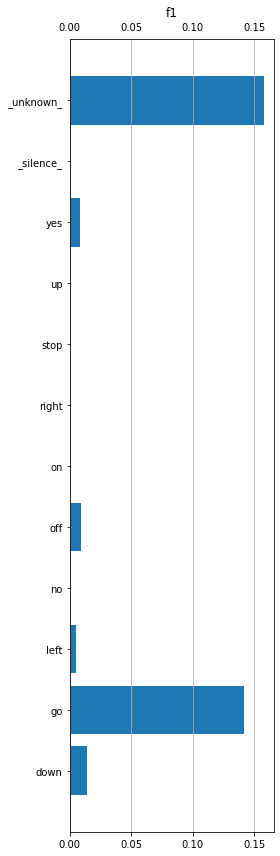

In [15]:
trainer = Trainer(gpus=gpus, max_epochs=max_epochs,
    check_val_every_n_epoch= check_val_every_n_epoch,
    num_sanity_val_steps=num_sanity_val_steps)

trainer.fit(net, trainloader, validloader)
trainer.test(net, testloader)
#added validloader, in order to reach validation_step